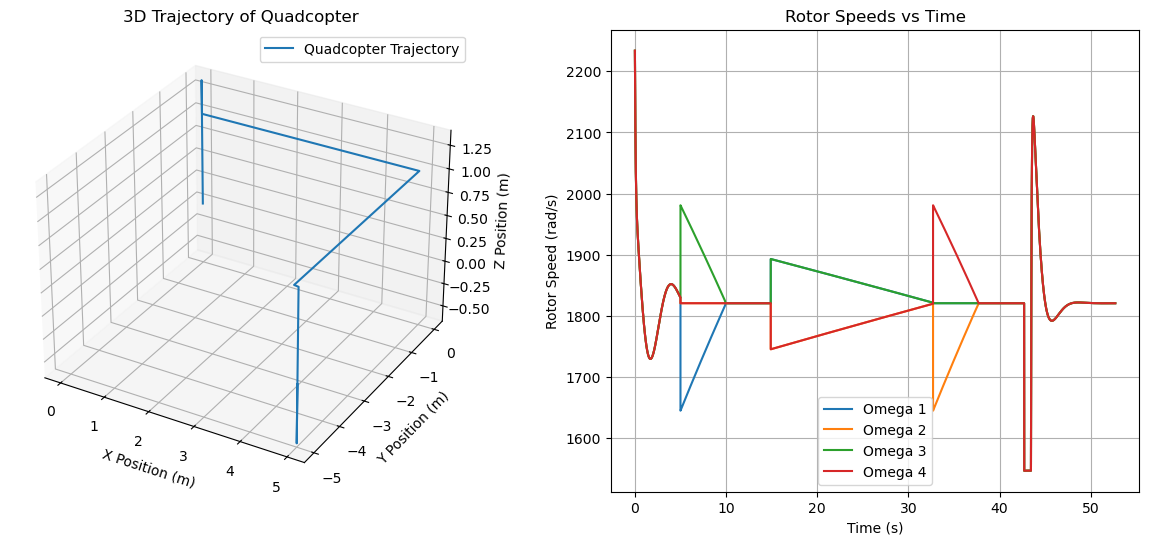

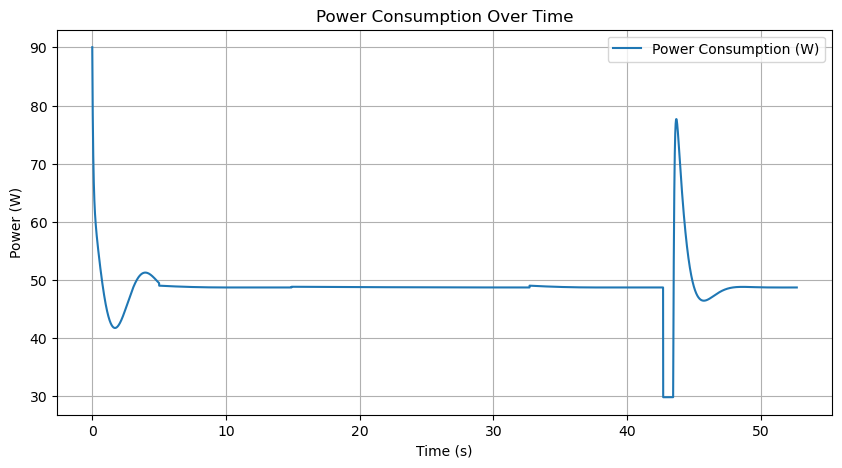

Average Power Consumption: 48.82 W


In [43]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Constants
k = 5.02e-7  # Lift coefficient
b = 5.02e-8  # Drag coefficient (yaw control)
l = 0.1225  # Distance from rotor to center of mass (meters)
m = 0.6783  # Mass of the quadcopter (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
dt = 0.001  # Time step

# PID Controller parameters
Kp = 10  # proportional gain
Ki = 20   # integral gain
Kd = 10  # derivative gain
setpoint = 1  # desired height (m)

# Initial conditions
height = 0  # initial height (m)
velocity = 0  # initial velocity (m/s)
integral_error = 0  # initial integral of error
previous_error = setpoint - height

# Trajectory and rotor speed data
trajectory_x, trajectory_y, trajectory_z = [], [], []
omega_1_values, omega_2_values, omega_3_values, omega_4_values = [], [], [], []
time_steps = []
velocities_x, velocities_y, velocities_z = [], [], []

rotor_diameter = 0.127  # Rotor diameter in meters
rotor_radius = rotor_diameter / 2
rho = 1.225  # Air density (kg/m^3)
A = np.pi * rotor_radius**2  # Rotor disc area (m^2)

def update_position_and_omegas(x, y, z, vx, vy, vz, rotor_speeds, time):
    trajectory_x.append(x)
    trajectory_y.append(y)
    trajectory_z.append(z)
    velocities_x.append(vx)
    velocities_y.append(vy)
    velocities_z.append(vz)
    omega_1_values.append(rotor_speeds[0])
    omega_2_values.append(rotor_speeds[1])
    omega_3_values.append(rotor_speeds[2])
    omega_4_values.append(rotor_speeds[3])
    time_steps.append(time)

# 1. Vertical ascent using PID Controller
time = [0]
heights = [height]
omegas = []
x_velocity = y_velocity = z_velocity = 0

for t in np.arange(dt, 5, dt):  # Simulate for 5 seconds
    error = setpoint - height
    integral_error += error * dt
    derivative_error = (error - previous_error) / dt

    # PID controller output for net thrust
    net_thrust = Kp * error + Ki * integral_error + Kd * derivative_error

    # Calculate total thrust
    thrust_per_rotor = net_thrust / 4
    if thrust_per_rotor < 0:
        thrust_per_rotor = 0  # no negative thrust
    omega = math.sqrt(thrust_per_rotor / k)

    # Calculate acceleration
    total_thrust = 4 * k * omega**2
    acceleration = (total_thrust / m) - g

    # Update state
    velocity += acceleration * dt
    height += velocity * dt

    # Store results
    time.append(t)
    heights.append(height)
    omegas.append(omega)

    previous_error = error

    # Update trajectory data
    update_position_and_omegas(0, 0, height, 0, 0, velocity, [omega, omega, omega, omega], t)

# 2. Horizontal motion
def compute_rotor_speeds(thrust, roll, pitch, yaw):
    omega_1_squared = (thrust / (4 * k)) - (pitch / (2 * l * k)) - (yaw / (4 * b))
    omega_2_squared = (thrust / (4 * k)) + (roll / (2 * l * k)) + (yaw / (4 * b))
    omega_3_squared = (thrust / (4 * k)) + (pitch / (2 * l * k)) - (yaw / (4 * b))
    omega_4_squared = (thrust / (4 * k)) - (roll / (2 * l * k)) + (yaw / (4 * b))

    return [
        math.sqrt(max(omega_1_squared, 0)),
        math.sqrt(max(omega_2_squared, 0)),
        math.sqrt(max(omega_3_squared, 0)),
        math.sqrt(max(omega_4_squared, 0))
    ]

def distance(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2 + (pos1[2] - pos2[2])**2)

current_position = [0, 0, 1]  # Start at 1m height after ascent
target_position = [5, 0, 1]
while distance(current_position, target_position) > 0.1:
    thrust = m * g
    pitch = (target_position[0] - current_position[0]) * 0.015
    rotor_speeds = compute_rotor_speeds(thrust, 0, pitch, 0)
    x_velocity = 1 * dt  # Simulated horizontal velocity
    update_position_and_omegas(current_position[0], current_position[1], current_position[2], x_velocity, 0, 0, rotor_speeds, time[-1])
    current_position[0] += x_velocity
    time.append(time[-1] + dt)

# 3. Hover
for _ in range(int(5.0 / dt)):
    thrust = m * g
    rotor_speeds = compute_rotor_speeds(thrust, 0, 0, 0)
    update_position_and_omegas(current_position[0], current_position[1], current_position[2], 0, 0, 0, rotor_speeds, time[-1])
    time.append(time[-1] + dt)

# 4. Yaw 90 degrees to the left
target_yaw = -90
current_yaw = 0
while abs(current_yaw - target_yaw) > 1:
    thrust = m * g
    yaw = (target_yaw - current_yaw) * 0.0006
    rotor_speeds = compute_rotor_speeds(thrust, 0, 0, yaw)
    update_position_and_omegas(current_position[0], current_position[1], current_position[2], 0, 0, 0, rotor_speeds, time[-1])
    current_yaw -= 5 * dt  # Simulated yaw change
    time.append(time[-1] + dt)

# 5. Second horizontal motion
target_position = [5, -5, 1]
while distance(current_position, target_position) > 0.1:
    thrust = m * g
    roll = (target_position[1] - current_position[1]) * 0.015
    rotor_speeds = compute_rotor_speeds(thrust, roll, 0, 0)
    y_velocity = -1 * dt  # Simulated horizontal velocity
    update_position_and_omegas(current_position[0], current_position[1], current_position[2], 0, y_velocity, 0, rotor_speeds, time[-1])
    current_position[1] += y_velocity
    time.append(time[-1] + dt)

# 6. Hover
for _ in range(int(5.0 / dt)):
    thrust = m * g
    rotor_speeds = compute_rotor_speeds(thrust, 0, 0, 0)
    update_position_and_omegas(current_position[0], current_position[1], current_position[2], 0, 0, 0, rotor_speeds, time[-1])
    time.append(time[-1] + dt)
    
#7. Vertical Descent with PID
# PID Controller parameters
Kp = 20  # proportional gain
Ki = 20   # integral gain
Kd = 10  # derivative gain
velocity = 0  # initial velocity (m/s)
setpoint = 0
height = 1
integral_error = 0  # initial integral of error
previous_error = setpoint - height
curtime = time[-1]
for t in np.arange(0, 10, dt):  # Simulate for 10 seconds
    error = setpoint-height
    integral_error += error * dt
    derivative_error = (error - previous_error) / dt

    # PID controller output for net thrust
    net_thrust = Kp * error + Ki * integral_error + Kd * derivative_error

    # Calculate total thrust
    thrust_per_rotor = net_thrust / 4
    if thrust_per_rotor <= 1.2:
        thrust_per_rotor = 1.2  # reasonable thrust
    omega = math.sqrt(thrust_per_rotor / k)
    # Calculate acceleration
    total_thrust = 4 * k * omega**2
    acceleration = (total_thrust / m) - g
    # Update state
    velocity += acceleration * dt
    height += velocity * dt
    # Store results
    time.append(curtime + t)
    heights.append(height)
    omegas.append(omega)
    previous_error = error
    # Update trajectory data
    update_position_and_omegas(5, -5, height, 0, 0, velocity, [omega, omega, omega, omega],  curtime + t)
################

# Plot the 3D trajectory
fig = plt.figure(figsize=(15, 6))

# 3D Trajectory Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(trajectory_x, trajectory_y, trajectory_z, label="Quadcopter Trajectory")
ax1.set_xlabel("X Position (m)")
ax1.set_ylabel("Y Position (m)")
ax1.set_zlabel("Z Position (m)")
ax1.set_title("3D Trajectory of Quadcopter")
ax1.legend()

# Rotor Speeds Plot
ax2 = fig.add_subplot(122)
ax2.plot(time_steps, omega_1_values, label='Omega 1')
ax2.plot(time_steps, omega_2_values, label='Omega 2')
ax2.plot(time_steps, omega_3_values, label='Omega 3')
ax2.plot(time_steps, omega_4_values, label='Omega 4')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Rotor Speed (rad/s)')
ax2.set_title('Rotor Speeds vs Time')
ax2.legend()
ax2.grid()

plt.show()

# # Initialize total energy consumption
# total_energy = 0

# # Calculate energy consumption for each time step
# for i in range(len(time_steps)):
#     omega1 = omega_1_values[i]
#     omega2 = omega_2_values[i]
#     omega3 = omega_3_values[i]
#     omega4 = omega_4_values[i]
    
#     # Energy for current time step
#     energy = k * (omega1**2 + omega2**2 + omega3**2 + omega4**2) * dt
#     total_energy += energy

# # Calculate average energy consumption
# simulation_duration = time_steps[-1] - time_steps[0]
# average_energy = total_energy / simulation_duration

# print(f"Total Energy Consumption: {total_energy:.2f} J")
# print(f"Average Energy Consumption: {average_energy:.2f} W")

power_consumptions = []
for i in range(len(omega_1_values)):
    omega1 = omega_1_values[i]
    omega2 = omega_2_values[i]
    omega3 = omega_3_values[i]
    omega4 = omega_4_values[i]

    # Compute thrust for all rotors
    thrust1 = k * omega1**2
    thrust2 = k * omega2**2
    thrust3 = k * omega3**2
    thrust4 = k * omega4**2

# Compute induced velocity for each rotor
    v_induced1 = np.sqrt(thrust1 / (2 * rho * A))
    v_induced2 = np.sqrt(thrust2 / (2 * rho * A))
    v_induced3 = np.sqrt(thrust3 / (2 * rho * A))
    v_induced4 = np.sqrt(thrust4 / (2 * rho * A))

    # Compute power for each rotor
    power1 = thrust1 * v_induced1
    power2 = thrust2 * v_induced2
    power3 = thrust3 * v_induced3
    power4 = thrust4 * v_induced4

    # Compute total power
    total_power = power1 + power2 + power3 + power4
    power_consumptions.append(total_power)



# Plot power consumption over time
plt.figure(figsize=(10, 5))
plt.plot(time_steps, power_consumptions, label='Power Consumption (W)')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.title('Power Consumption Over Time')
plt.legend()
plt.grid()
plt.show()
average_power = sum(power_consumptions) / len(power_consumptions)
print(f"Average Power Consumption: {average_power:.2f} W")
